# CAPSTONE PROJECT (IBM Data Science)
This notebook contains the source code for the Coursera Capstone Project on Data Science by IBM and Coursera

### Importing libraries

In [1]:
# !conda install beautifulsoup4

from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv

In [2]:
pd.set_option('max_colwidth', 800)


### Fetching the source webpage and assigining the variable source to it and iniatilizing the beautifulsoup object for the soup variable.

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text 
soup = BeautifulSoup(source, 'html.parser')

### Scraping the HTML.

In [4]:
postalCodeList = []
boroughList = []
neighborhoodList = []

for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text.rstrip('\n')) # remove the new line char from neighborhood cell
        boroughList.append(cells[1].text.rstrip('\n')) # remove the new line char from neighborhood cell
        neighborhoodList.append(cells[2].text.rstrip('\n')) # remove the new line char from neighborhood cell

### Converting the scraped data into dataframe.

In [5]:
toronto_neighorhood = [('PostalCode', postalCodeList),
                      ('Borough', boroughList),
                      ('Neighborhood', neighborhoodList)]
toronto_df = pd.DataFrame.from_dict(dict(toronto_neighorhood))
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


### Removing data which contains Borough as 'Not assigned'.

In [6]:
toronto_df_dropna = toronto_df[toronto_df.Borough != 'Not assigned'].reset_index(drop=True)
toronto_df_dropna.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


### Concatinating data which contains same PostalCode & Borough.

In [8]:
toronto_df_grouped = toronto_df_dropna.groupby(['PostalCode','Borough'], as_index=False).agg(lambda x: ','.join(x))
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Dealing with Neighborhood when its value is 'Not assigned'.

In [10]:
na_neigh_rows = toronto_df_grouped.Neighborhood == 'Not assigned'
toronto_df_grouped.loc[na_neigh_rows, 'Neighborhood'] = toronto_df_grouped.loc[na_neigh_rows, 'Borough']
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Dimensions of cleaned data frame.

In [11]:
toronto_df_cleaned = toronto_df_grouped
toronto_df_cleaned.shape

(103, 3)

### Downloading toronto_coordinates.csv file for coordinates.

In [13]:
!wget -q -O "toronto_coordinates.csv" http://cocl.us/Geospatial_data
print('Coordinates downloaded!')
coors = pd.read_csv('toronto_coordinates.csv')

Coordinates downloaded!


In [14]:
print(coors.shape)
coors.head()

(103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merging toronto_df_cleaned and coors data frames.

In [15]:
toronto_df_temp = toronto_df_cleaned.set_index('PostalCode')
coors_temp = coors.set_index('Postal Code')
toronto_df_coors = pd.concat([toronto_df_temp, coors_temp], axis=1, join='inner')

In [16]:
toronto_df_coors.index.name = 'PostalCode'
toronto_df_coors.reset_index(inplace=True)

In [17]:
temp_df_coors=toronto_df_coors
toronto_df_coors.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Installing folium.

In [18]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                       

### Importing libraries for maps.

In [24]:
import folium # Map plotting library
import numpy as np
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

### Installing geopy.

In [25]:
!conda install -c conda-forge geopy --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.21.0-py_0 conda-forge


geographiclib-1.50   | 34 KB     | ##################################### | 100% 
geopy-1.21.0         | 58 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


### Importing libraries for Nominatim.

In [29]:
from geopy.geocoders import Nominatim

### Fetching latitude & longitude of TORONTO.

In [30]:
address = 'Toronto'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Map of Toronto and its neighborhood.

In [185]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df_coors['Latitude'], toronto_df_coors['Longitude'], toronto_df_coors['Borough'], toronto_df_coors['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Fetching borough those contains Toronto.

In [32]:
borough_names = list(toronto_df_coors.Borough.unique())

borough_with_toronto = []

for x in borough_names:
    if "toronto" in x.lower():
        borough_with_toronto.append(x)
        
borough_with_toronto

['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']

In [33]:
toronto_df_toronto = toronto_df_coors[toronto_df_coors['Borough'].isin(borough_with_toronto)].reset_index(drop=True)
toronto_df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,The Danforth West / Riverdale,43.679557,-79.352188
2,M4L,East Toronto,India Bazaar / The Beaches West,43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### Map of places which contains 'Toronto' in borough column.

In [186]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df_toronto['Latitude'], toronto_df_toronto['Longitude'], toronto_df_toronto['Borough'], toronto_df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

### Foursquare API credentials.

In [35]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200422'

### Explore venues near by places using Foursquare.

In [36]:
radius = 500
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(toronto_df_toronto['Latitude'], toronto_df_toronto['Longitude'], toronto_df_toronto['PostalCode'], toronto_df_toronto['Borough'], toronto_df_toronto['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [37]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
print(venues_df.shape)
venues_df.head()

(1620, 9)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,East Toronto,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,East Toronto,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4K,East Toronto,The Danforth West / Riverdale,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [38]:
print(venues_df.groupby(["PostalCode", "Borough", "Neighborhood"]).count())
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

                                                                                                                                              Latitude  \
PostalCode Borough          Neighborhood                                                                                                                 
M4E        East Toronto     The Beaches                                                                                                              4   
M4K        East Toronto     The Danforth West / Riverdale                                                                                           43   
M4L        East Toronto     India Bazaar / The Beaches West                                                                                         21   
M4M        East Toronto     Studio District                                                                                                         40   
M4N        Central Toronto  Lawrence Park                                   

### Performing one-hot encoding to analyze neighbourhoods.

In [39]:
# one hot encoding
toronto_central_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
toronto_central_onehot['PostalCode'] = venues_df['PostalCode'] 
toronto_central_onehot['Borough'] = venues_df['Borough'] 
toronto_central_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_central_onehot.columns[-3:]) + list(toronto_central_onehot.columns[:-3])
toronto_central_onehot = toronto_central_onehot[fixed_columns]

print(toronto_central_onehot.shape)
toronto_central_onehot.head()

(1620, 233)


,PostalCode,Borough,Neighborhoods,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4K,East Toronto,The Danforth West / Riverdale,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Fetching frequency of occurance of each category in an area.

In [40]:
toronto_central_venues_freq = toronto_central_onehot.groupby(['PostalCode', 'Borough', 'Neighborhoods']).mean().reset_index()
print(toronto_central_venues_freq.shape)
toronto_central_venues_freq.head()

(39, 233)


,PostalCode,Borough,Neighborhoods,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
1,M4K,East Toronto,The Danforth West / Riverdale,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,...,0.0,0.0,0.023256,0.0,0.0,0.0,0.0,0.000,0.0,0.023256
2,M4L,East Toronto,India Bazaar / The Beaches West,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
3,M4M,East Toronto,Studio District,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.025,0.0,0.025000
4,M4N,Central Toronto,Lawrence Park,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000


### Top 10 venue type occurance in each area.

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_central_venues_freq['PostalCode']
neighborhoods_venues_sorted['Borough'] = toronto_central_venues_freq['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_central_venues_freq['Neighborhoods']

for ind in np.arange(toronto_central_venues_freq.shape[0]):
    row_categories = toronto_central_venues_freq.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
neighborhoods_venues_sorted

,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,M5V,Downtown Toronto,CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst Quay / South Niagara / Island airport,Airport Lounge,Airport Service,Airport Terminal,Airport,Harbor / Marina,Coffee Shop,Plane,Rental Car Location,Sculpture Garden,Boat or Ferry
32,M6J,West Toronto,Little Portugal / Trinity,Bar,Restaurant,Café,Vietnamese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Men's Store,Yoga Studio,Japanese Restaurant,Juice Bar
25,M5S,Downtown Toronto,University of Toronto / Harbord,Café,Bookstore,Bar,Italian Restaurant,Japanese Restaurant,Bakery,Restaurant,Sandwich Place,Beer Bar,Beer Store
3,M4M,East Toronto,Studio District,Café,Coffee Shop,Gastropub,Brewery,Bakery,American Restaurant,Neighborhood,Sandwich Place,Cheese Shop,Pet Store
15,M5C,Downtown Toronto,St. James Town,Café,Coffee Shop,Gastropub,Cocktail Bar,American Restaurant,Hotel,Italian Restaurant,Clothing Store,Art Gallery,Seafood Restaurant
26,M5T,Downtown Toronto,Kensington Market / Chinatown / Grange Park,Café,Coffee Shop,Vietnamese Restaurant,Mexican Restaurant,Bar,Vegetarian / Vegan Restaurant,Gaming Cafe,Bakery,Dessert Shop,Grocery Store
33,M6K,West Toronto,Brockton / Parkdale Village / Exhibition Place,Café,Nightclub,Breakfast Spot,Coffee Shop,Stadium,Bar,Intersection,Bakery,Italian Restaurant,Climbing Gym
14,M5B,Downtown Toronto,"Garden District, Ryerson",Clothing Store,Coffee Shop,Café,Japanese Restaurant,Cosmetics Shop,Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Diner,Tea Room
6,M4R,Central Toronto,North Toronto West,Clothing Store,Coffee Shop,Yoga Studio,Sporting Goods Shop,Fast Food Restaurant,Diner,Dessert Shop,Mexican Restaurant,Cosmetics Shop,Chinese Restaurant
19,M5J,Downtown Toronto,Harbourfront East / Union Station / Toronto Islands,Coffee Shop,Aquarium,Restaurant,Café,Italian Restaurant,Hotel,Scenic Lookout,Fried Chicken Joint,Brewery,Sporting Goods Shop


### Separating venue categories for cluster count.

In [45]:
toronto_grouped_clustering = toronto_central_venues_freq.drop(['PostalCode','Borough','Neighborhoods'], 1)
toronto_grouped_clustering.head()

,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0,0.0,0.0,...,0.0,0.0,0.023256,0.0,0.0,0.0,0.0,0.000,0.0,0.023256
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.025,0.0,0.025000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000000


### Defining function for ploting.

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [54]:
max_no_clusters = 10 # Maximum range of clusters

In [55]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_no_clusters) :
    
    # Run k-means clustering
    tgc = toronto_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(tgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(tgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

### Visualizing number of clusters with respective Silhouette Scores. 

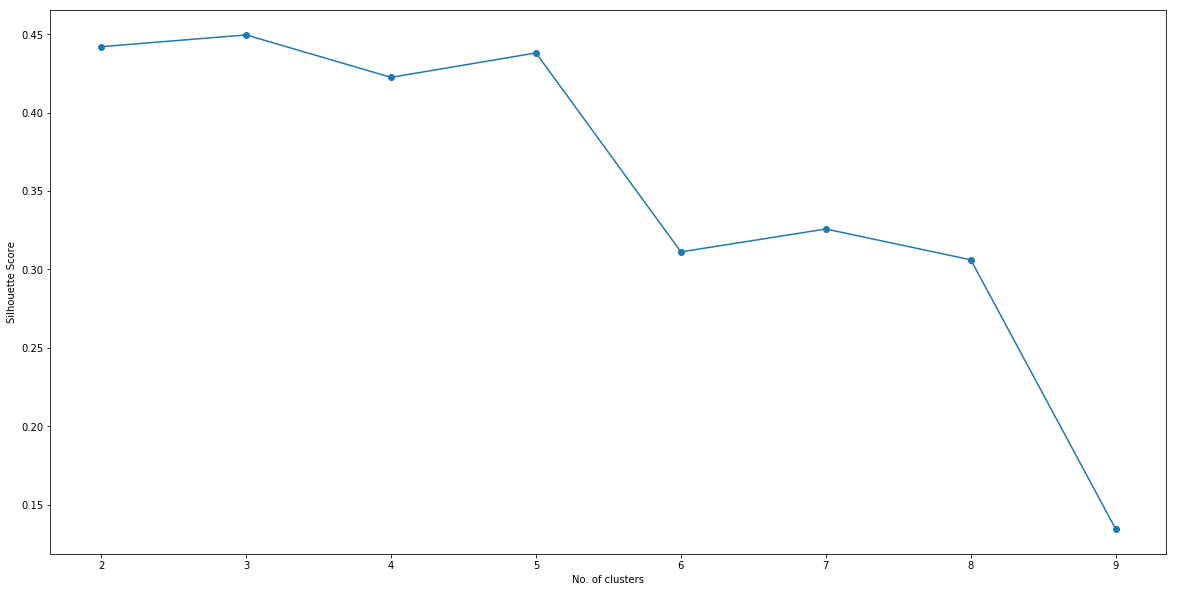

In [56]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

### Resulting optimum number of clusters.

In [58]:
K_cluster_opt = np.argmax(scores) + 2  # Finds the optimal value
K_cluster_opt

3

### Assigning Cluster column to each Location.

In [61]:
kclusters = K_cluster_opt

toronto_central_venues_freq_clustering = toronto_central_venues_freq.drop(['PostalCode', 'Borough', 'Neighborhoods'], 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_central_venues_freq_clustering)

toronto_central_clustered_df = toronto_df_toronto
toronto_central_clustered_df['Cluster'] = kmeans.labels_

toronto_central_clustered_df = toronto_central_clustered_df.join(neighborhoods_venues_sorted.drop(['Borough', 'Neighborhoods'], 1).set_index('PostalCode'), on='PostalCode')
toronto_central_clustered_df.sort_values(['Cluster'] + freqColumns, inplace=True)
toronto_central_clustered_df.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,0,Sandwich Place,Dessert Shop,Pizza Place,Italian Restaurant,Coffee Shop,Gym,Café,Sushi Restaurant,Pharmacy,Seafood Restaurant
2,M4L,East Toronto,India Bazaar / The Beaches West,43.668999,-79.315572,0,Sandwich Place,Park,Fast Food Restaurant,Food & Drink Shop,Liquor Store,Burrito Place,Restaurant,Italian Restaurant,Ice Cream Shop,Steakhouse
10,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,1,Park,Playground,Trail,Cupcake Shop,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
8,M4T,Central Toronto,Moore Park / Summerhill East,43.689574,-79.383160,1,Park,Trail,Playground,Summer Camp,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
22,M5N,Central Toronto,Roselawn,43.711695,-79.416936,2,Garden,Ice Cream Shop,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


### Clusters on Map representation.

In [187]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_central_clustered_df['Latitude'], toronto_central_clustered_df['Longitude'], toronto_central_clustered_df['PostalCode'], toronto_central_clustered_df['Borough'], toronto_central_clustered_df['Neighborhood'], toronto_central_clustered_df['Cluster']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Defining funtions to get all the bear by venues.

In [65]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
   
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

### Unique Venues.

In [67]:
toronto_venues = getNearbyVenues(names=toronto_df_toronto['Neighborhood'],
                                latitudes=toronto_df_toronto['Latitude'],
                                longitudes=toronto_df_toronto['Longitude'])
toronto_venues['Venue Category'].unique()[:100]

The Beaches
The Danforth West / Riverdale
India Bazaar / The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park / Summerhill East
Summerhill West / Rathnelly / South Hill / Forest Hill SE / Deer Park
Rosedale
St. James Town / Cabbagetown
Church and Wellesley
Regent Park / Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond / Adelaide / King
Harbourfront East / Union Station / Toronto Islands
Toronto Dominion Centre / Design Exchange
Commerce Court / Victoria Hotel
Roselawn
Forest Hill North & West
The Annex / North Midtown / Yorkville
University of Toronto / Harbord
Kensington Market / Chinatown / Grange Park
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst Quay / South Niagara / Island airport
Stn A PO Boxes
First Canadian Place / Underground city
Christie
Dufferin / Dovercourt Village
Little Portugal / Trinity
Brockton / Parkdale Village / Exhibition Place
High Park / 

array(['Trail', 'Health Food Store', 'Pub', 'Neighborhood',
       'Greek Restaurant', 'Cosmetics Shop', 'Italian Restaurant',
       'Ice Cream Shop', 'Yoga Studio', 'Brewery',
       'Fruit & Vegetable Store', 'Pizza Place', 'Bookstore',
       'Restaurant', 'Dessert Shop', 'Juice Bar', 'Bubble Tea Shop',
       'Spa', 'Diner', 'Grocery Store', 'Furniture / Home Store', 'Café',
       'Coffee Shop', 'Bakery', 'Caribbean Restaurant',
       'Indian Restaurant', 'Japanese Restaurant', 'American Restaurant',
       'Frozen Yogurt Shop', 'Lounge', 'Liquor Store', 'Gym',
       'Fish & Chips Shop', 'Fast Food Restaurant', 'Sushi Restaurant',
       'Park', 'Pet Store', 'Steakhouse', 'Burrito Place',
       'Movie Theater', 'Sandwich Place', 'Food & Drink Shop',
       'Fish Market', 'Gay Bar', 'Cheese Shop',
       'Middle Eastern Restaurant', 'Comfort Food Restaurant',
       'Thai Restaurant', 'Seafood Restaurant', 'Stationery Store',
       'Coworking Space', 'Wine Bar', 'Bar', 'Gym / 

### Getting count with respective to Neighbourhood.

In [68]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
Brockton / Parkdale Village / Exhibition Place,23,23,23,23,23,23
Business reply mail Processing CentrE,17,17,17,17,17,17
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst Quay / South Niagara / Island airport,16,16,16,16,16,16
Central Bay Street,65,65,65,65,65,65
Christie,18,18,18,18,18,18
Church and Wellesley,72,72,72,72,72,72
Commerce Court / Victoria Hotel,100,100,100,100,100,100
Davisville,34,34,34,34,34,34


### Unique Venue Categories.

In [69]:
toronto_venues['Venue Category'].unique()[:100]

array(['Trail', 'Health Food Store', 'Pub', 'Neighborhood',
       'Greek Restaurant', 'Cosmetics Shop', 'Italian Restaurant',
       'Ice Cream Shop', 'Yoga Studio', 'Brewery',
       'Fruit & Vegetable Store', 'Pizza Place', 'Bookstore',
       'Restaurant', 'Dessert Shop', 'Juice Bar', 'Bubble Tea Shop',
       'Spa', 'Diner', 'Grocery Store', 'Furniture / Home Store', 'Café',
       'Coffee Shop', 'Bakery', 'Caribbean Restaurant',
       'Indian Restaurant', 'Japanese Restaurant', 'American Restaurant',
       'Frozen Yogurt Shop', 'Lounge', 'Liquor Store', 'Gym',
       'Fish & Chips Shop', 'Fast Food Restaurant', 'Sushi Restaurant',
       'Park', 'Pet Store', 'Steakhouse', 'Burrito Place',
       'Movie Theater', 'Sandwich Place', 'Food & Drink Shop',
       'Fish Market', 'Gay Bar', 'Cheese Shop',
       'Middle Eastern Restaurant', 'Comfort Food Restaurant',
       'Thai Restaurant', 'Seafood Restaurant', 'Stationery Store',
       'Coworking Space', 'Wine Bar', 'Bar', 'Gym / 

### Checking for Pharmacy, Department Store, Grocery Store.

In [70]:
"Pharmacy" in toronto_venues['Venue Category'].unique()

True

In [72]:
"Department Store" in toronto_venues['Venue Category'].unique()

True

In [73]:
"Grocery Store" in toronto_venues['Venue Category'].unique()

True

### Creating a dataset to hold Pharmacy, Grocery Store, Department Store frequency values. 

In [112]:
corona_req = toronto_central_venues_freq[["Neighborhoods","Pharmacy","Grocery Store","Department Store"]]

In [113]:
from sklearn.cluster import KMeans
toclusters = kclusters

to_clustering = corona_req.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=toclusters, random_state=1)
kmeans.fit_transform(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [188]:
to_merged = corona_req.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [189]:
to_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
to_merged.head(5)

,Neighborhood,Pharmacy,Grocery Store,Department Store,Cluster Labels
0,The Beaches,0.0,0.000000,0.0,0
1,The Danforth West / Riverdale,0.0,0.023256,0.0,0
2,India Bazaar / The Beaches West,0.0,0.000000,0.0,0
3,Studio District,0.0,0.000000,0.0,0
4,Lawrence Park,0.0,0.000000,0.0,0


In [190]:
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1620, 11)


,Neighborhood,Pharmacy,Grocery Store,Department Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,0.0,0.000000,0.0,0,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
0,The Beaches,0.0,0.000000,0.0,0,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
0,The Beaches,0.0,0.000000,0.0,0,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
0,The Beaches,0.0,0.000000,0.0,0,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
1,The Danforth West / Riverdale,0.0,0.023256,0.0,0,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


### Defining separate dataframes for each category - Pharmacy, Grocery Store, Department Store.

In [203]:
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.columns
to_merged_Pharmacy = to_merged[to_merged['Venue Category'] == "Pharmacy" ].reset_index(drop=True)
to_merged_grocery = to_merged[to_merged['Venue Category'] == "Grocery Store"].reset_index(drop=True)
to_merged_department = to_merged[to_merged['Venue Category'] == "Department Store"].reset_index(drop=True)

### Pharmacy dataframe.

In [204]:
to_merged_Pharmacy.drop(['Grocery Store','Department Store'],axis=1,inplace=True)
to_merged_Pharmacy.head()

,Neighborhood,Pharmacy,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Annex / North Midtown / Yorkville,0.045455,0,43.672710,-79.405678,Shoppers Drug Mart,43.674959,-79.407986,Pharmacy
1,Kensington Market / Chinatown / Grange Park,0.017857,0,43.653206,-79.400049,Shoppers Drug Mart,43.653702,-79.406093,Pharmacy
2,Dufferin / Dovercourt Village,0.125000,0,43.669005,-79.442259,Shoppers Drug Mart,43.666745,-79.447446,Pharmacy
3,Dufferin / Dovercourt Village,0.125000,0,43.669005,-79.442259,Rexall,43.667504,-79.442086,Pharmacy
4,St. James Town / Cabbagetown,0.021739,0,43.667967,-79.367675,Shoppers Drug Mart,43.663998,-79.367830,Pharmacy


### Grocery Store dataframe.

In [205]:
to_merged_grocery.drop(['Pharmacy','Department Store'],axis=1,inplace=True)
to_merged_grocery.head()

,Neighborhood,Grocery Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kensington Market / Chinatown / Grange Park,0.035714,0,43.653206,-79.400049,金城超級市場 Lucky Moose Food Mart,43.653651,-79.394413,Grocery Store
1,Kensington Market / Chinatown / Grange Park,0.035714,0,43.653206,-79.400049,Perola Supermarket,43.654894,-79.402146,Grocery Store
2,Brockton / Parkdale Village / Exhibition Place,0.043478,0,43.636847,-79.428191,Queen Supermarket,43.634265,-79.429112,Grocery Store
3,High Park / The Junction South,0.043478,0,43.661608,-79.464763,Tim & Sue's No Frills,43.664243,-79.468643,Grocery Store
4,Stn A PO Boxes,0.010309,0,43.646435,-79.374846,Loblaws,43.645427,-79.369789,Grocery Store


### Department Store dataframe.

In [206]:
to_merged_department.drop(['Pharmacy','Grocery Store'],axis=1,inplace=True)
to_merged_department.head()

,Neighborhood,Department Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Commerce Court / Victoria Hotel,0.010000,0,43.648198,-79.379817,Hudson's Bay,43.652040,-79.380391,Department Store
1,Harbourfront East / Union Station / Toronto Islands,0.010000,0,43.640816,-79.381752,Winners,43.642063,-79.379001,Department Store
2,First Canadian Place / Underground city,0.010000,0,43.648429,-79.382280,Hudson's Bay,43.652040,-79.380391,Department Store
3,Central Bay Street,0.015385,0,43.657952,-79.387383,Marshalls,43.659308,-79.382462,Department Store
4,St. James Town,0.023810,0,43.651494,-79.375418,Hudson's Bay,43.652040,-79.380391,Department Store


### Cluster Map for Pharmacy.

In [207]:
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=14)

# set color scheme for the clusters


# add markers to the map
markers_colors={}
markers_colors[0] = 'red'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
for lat, lon, cluster, venue in zip(to_merged_Pharmacy['Neighborhood Latitude'], to_merged_Pharmacy['Neighborhood Longitude'], to_merged_Pharmacy['Cluster Labels'],to_merged_Pharmacy['Venue']):
    
    label = folium.Popup('{} : - Cluster {}'.format(venue, cluster), parse_html=True)
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color =markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Map for Grocery Store.

In [208]:
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=14)

# set color scheme for the clusters


# add markers to the map
markers_colors={}
markers_colors[0] = 'red'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
for lat, lon, cluster, venue in zip(to_merged_grocery['Neighborhood Latitude'], to_merged_grocery['Neighborhood Longitude'], to_merged_grocery['Cluster Labels'],to_merged_grocery['Venue']):
    
    label = folium.Popup('{} : - Cluster {}'.format(venue, cluster), parse_html=True)
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color =markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Map for Department Store.

In [209]:
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=14)

# set color scheme for the clusters


# add markers to the map
markers_colors={}
markers_colors[0] = 'red'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
for lat, lon, cluster, venue in zip(to_merged_department['Neighborhood Latitude'], to_merged_department['Neighborhood Longitude'], to_merged_department['Cluster Labels'],to_merged_department['Venue']):
    
    label = folium.Popup('{} : - Cluster {}'.format(venue, cluster), parse_html=True)
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color =markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster detailing for Pharmacy:

#### Cluster 0:

In [210]:
to_merged_Pharmacy.loc[(to_merged_Pharmacy['Cluster Labels'] ==0) & (to_merged_Pharmacy['Venue Category'] == 'Pharmacy') ]

,Neighborhood,Pharmacy,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Annex / North Midtown / Yorkville,0.045455,0,43.672710,-79.405678,Shoppers Drug Mart,43.674959,-79.407986,Pharmacy
1,Kensington Market / Chinatown / Grange Park,0.017857,0,43.653206,-79.400049,Shoppers Drug Mart,43.653702,-79.406093,Pharmacy
2,Dufferin / Dovercourt Village,0.125000,0,43.669005,-79.442259,Shoppers Drug Mart,43.666745,-79.447446,Pharmacy
3,Dufferin / Dovercourt Village,0.125000,0,43.669005,-79.442259,Rexall,43.667504,-79.442086,Pharmacy
4,St. James Town / Cabbagetown,0.021739,0,43.667967,-79.367675,Shoppers Drug Mart,43.663998,-79.367830,Pharmacy
5,Davisville,0.029412,0,43.704324,-79.388790,Shoppers Drug Mart,43.707806,-79.389893,Pharmacy
6,St. James Town,0.011905,0,43.651494,-79.375418,Rexall,43.648182,-79.373870,Pharmacy


#### Cluster 1:

In [172]:
to_merged_Pharmacy.loc[(to_merged_Pharmacy['Cluster Labels'] ==1) & (to_merged_Pharmacy['Venue Category'] == 'Pharmacy') ]

,Neighborhood,Pharmacy,Grocery Store,Department Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


#### Cluster 3:

In [171]:
to_merged_Pharmacy.loc[(to_merged_Pharmacy['Cluster Labels'] ==2) & (to_merged_Pharmacy['Venue Category'] == 'Pharmacy') ]

,Neighborhood,Pharmacy,Grocery Store,Department Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


### Cluster detailing for Grocery Store:

#### Cluster 0:

In [160]:
to_merged_grocery.loc[(to_merged_grocery['Cluster Labels'] ==0) & (to_merged_grocery['Venue Category'] == 'Grocery Store') ]

,Neighborhood,Pharmacy,Grocery Store,Department Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Danforth West / Riverdale,0.000000,0.023256,0.00000,0,43.679557,-79.352188,Bulk Barn,43.676790,-79.355865,Grocery Store
1,St. James Town / Cabbagetown,0.021739,0.021739,0.00000,0,43.667967,-79.367675,No Frills,43.663515,-79.367166,Grocery Store
2,Church and Wellesley,0.000000,0.013889,0.00000,0,43.665860,-79.383160,H Mart,43.669332,-79.386257,Grocery Store
3,St. James Town,0.011905,0.011905,0.02381,0,43.651494,-79.375418,Bulk Barn,43.649994,-79.370099,Grocery Store
4,Berczy Park,0.000000,0.017544,0.00000,0,43.644771,-79.373306,Loblaws,43.645427,-79.369789,Grocery Store
5,Kensington Market / Chinatown / Grange Park,0.017857,0.035714,0.00000,0,43.653206,-79.400049,Perola Supermarket,43.654894,-79.402146,Grocery Store
6,Kensington Market / Chinatown / Grange Park,0.017857,0.035714,0.00000,0,43.653206,-79.400049,金城超級市場 Lucky Moose Food Mart,43.653651,-79.394413,Grocery Store
7,Stn A PO Boxes,0.000000,0.010309,0.00000,0,43.646435,-79.374846,Loblaws,43.645427,-79.369789,Grocery Store
8,Dufferin / Dovercourt Village,0.125000,0.062500,0.00000,0,43.669005,-79.442259,FreshCo,43.667918,-79.440754,Grocery Store
9,Brockton / Parkdale Village / Exhibition Place,0.000000,0.043478,0.00000,0,43.636847,-79.428191,Queen Supermarket,43.634265,-79.429112,Grocery Store


#### Cluster 1:

In [161]:
to_merged_grocery.loc[(to_merged_grocery['Cluster Labels'] ==1) & (to_merged_grocery['Venue Category'] == 'Grocery Store') ]

,Neighborhood,Pharmacy,Grocery Store,Department Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11,Christie,0.0,0.222222,0.0,1,43.669542,-79.422564,Fiesta Farms,43.668471,-79.420485,Grocery Store
12,Christie,0.0,0.222222,0.0,1,43.669542,-79.422564,Loblaws,43.671657,-79.421364,Grocery Store
13,Christie,0.0,0.222222,0.0,1,43.669542,-79.422564,Foto Grocery,43.667979,-79.428217,Grocery Store
14,Christie,0.0,0.222222,0.0,1,43.669542,-79.422564,Sobeys Dupont,43.670977,-79.427573,Grocery Store


#### Cluster 2:

In [162]:
to_merged_grocery.loc[(to_merged_grocery['Cluster Labels'] ==2) & (to_merged_grocery['Venue Category'] == 'Grocery Store') ]

,Neighborhood,Pharmacy,Grocery Store,Department Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


### Cluster detailing for Department Store:

#### Cluster 0:

In [181]:
to_merged_department.loc[(to_merged_department['Cluster Labels'] ==0) & (to_merged_department['Venue Category'] == 'Department Store') ]

,Neighborhood,Pharmacy,Grocery Store,Department Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Commerce Court / Victoria Hotel,0.000000,0.000000,0.010000,0,43.648198,-79.379817,Hudson's Bay,43.652040,-79.380391,Department Store
1,Harbourfront East / Union Station / Toronto Islands,0.000000,0.000000,0.010000,0,43.640816,-79.381752,Winners,43.642063,-79.379001,Department Store
2,First Canadian Place / Underground city,0.000000,0.000000,0.010000,0,43.648429,-79.382280,Hudson's Bay,43.652040,-79.380391,Department Store
3,Central Bay Street,0.000000,0.000000,0.015385,0,43.657952,-79.387383,Marshalls,43.659308,-79.382462,Department Store
4,St. James Town,0.011905,0.011905,0.023810,0,43.651494,-79.375418,Hudson's Bay,43.652040,-79.380391,Department Store
5,"Garden District, Ryerson",0.000000,0.000000,0.010000,0,43.657162,-79.378937,Marshalls,43.659308,-79.382462,Department Store
6,St. James Town,0.011905,0.011905,0.023810,0,43.651494,-79.375418,Winners,43.647748,-79.374551,Department Store


#### Cluster 1:

In [182]:
to_merged_department.loc[(to_merged_department['Cluster Labels'] ==1) & (to_merged_department['Venue Category'] == 'Department Store') ]

,Neighborhood,Pharmacy,Grocery Store,Department Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


#### Cluster 2:

In [183]:
to_merged_department.loc[(to_merged_department['Cluster Labels'] ==2) & (to_merged_department['Venue Category'] == 'Department Store') ]

,Neighborhood,Pharmacy,Grocery Store,Department Store,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
7,Davisville North,0.0,0.0,0.142857,2,43.712751,-79.390197,Winners,43.713236,-79.393873,Department Store


## CONCLUSION:

#### Pharmacy-

There are 7 pharmacies located in cluster 0 where in cluster 1 & cluster 2, there are no pharmacies. (The data is provided in cluster detailing of Pharmacy section as a dataframe) 

#### Grocery Store-

There are 11 grocery stores located in cluster 0 and 4 in cluster 1. In cluster 2, there are grocery stores. (The data is provided in cluster detailing of Grocery Store section as a dataframe) 

#### Department Store-

There are 7 department stores located in cluster 0 and 1 in cluster 0. In cluster 1, there are grocery stores. (The data is provided in cluster detailing of Department Store section as a dataframe) 